In [1]:
import numpy as np
import pandas as pd
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, accuracy_score, confusion_matrix, classification_report
from collections import Counter

In [2]:
data_dir = "GAIP_data"

In [3]:
train_dir = data_dir + "//train//"
val_dir = data_dir + "//val//"
test_dir = data_dir + "//test//"

In [4]:
dim1 = []
dim2 = []
for sub_folders in os.listdir(train_dir):
    for imgs in os.listdir(train_dir + sub_folders):
        img = plt.imread(train_dir + sub_folders +'//' + imgs)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [5]:
dim1 = round(np.mean(dim1))
dim2 = round(np.mean(dim2))
print("Average dimensions of training images: ({},{})".format(dim1,dim2))

Average dimensions of training images: (331,390)


In [6]:
animal_class_nos = len(os.listdir(train_dir+"animal"))
bench_class_nos = len(os.listdir(train_dir+"bench"))
bike_class_nos = len(os.listdir(train_dir+"bike"))
car_class_nos = len(os.listdir(train_dir+"car"))
fire_hyrdrant_class_nos = len(os.listdir(train_dir+"fire_hydrant"))
person_class_nos = len(os.listdir(train_dir+"person"))
sign_class_nos = len(os.listdir(train_dir+"sign"))

In [7]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

Text(0.5, 1.0, 'Number of images in each class')

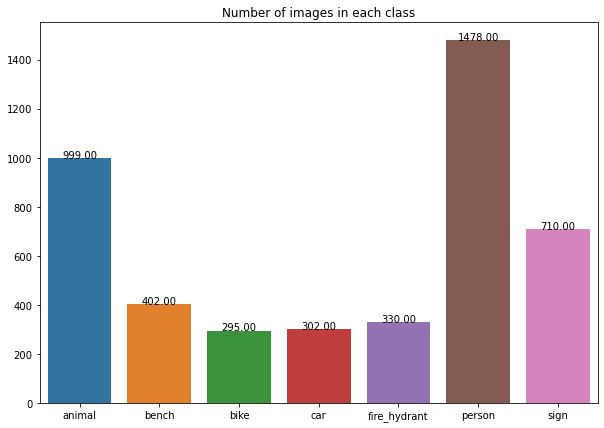

In [8]:
labels = ['animal', 'bench', 'bike', 'car', 'fire_hydrant', 'person', 'sign']

fig, ax = plt.subplots(figsize=(10,7))
ax = sns.barplot(x = labels, y = [animal_class_nos, bench_class_nos, bike_class_nos, car_class_nos, 
                                  fire_hyrdrant_class_nos, person_class_nos, sign_class_nos])
show_values_on_bars(ax)
plt.title("Number of images in each class")

In [9]:
data_gen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2, 
                             zoom_range = 0.20,
                             rotation_range = 7,
                             width_shift_range=0.15,  
                             height_shift_range=0.1,  
                             horizontal_flip=True)

train_data_gen = data_gen.flow_from_directory(train_dir,
                                             target_size = (331,390),
                                             batch_size = 16,
                                              shuffle = True,
                                             color_mode = 'rgb',
                                             class_mode = 'categorical')

val_test_gen = ImageDataGenerator(rescale = 1./255)


val_gen = val_test_gen.flow_from_directory(val_dir,
                                      target_size = (331, 390),
                                      batch_size = 16,
                                      shuffle = False,
                                      color_mode = 'rgb',
                                      class_mode = 'categorical')

test_gen = val_test_gen.flow_from_directory(test_dir,
                                      target_size = (331, 390),
                                      batch_size = 16,
                                      shuffle = False,
                                      color_mode = 'rgb',
                                      class_mode = 'categorical')

Found 4516 images belonging to 7 classes.
Found 614 images belonging to 7 classes.
Found 1101 images belonging to 7 classes.


In [10]:
counter = Counter(train_data_gen.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

In [11]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters = 64, kernel_size=3))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters = 128, kernel_size=3))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters = 256, kernel_size=3))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(units=256))
model.add(LeakyReLU())
model.add(Dropout(0.1))

model.add(Dense(units=7, activation='softmax'))

optimizer = Adam(learning_rate=0.01, decay=1e-5)

model.compile(optimizer = optimizer, 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

In [ ]:
stop = EarlyStopping(patience = 10, monitor = 'val_loss')
checkpoint = ModelCheckpoint(data_dir + '/smaller_model_checkpoints',
                                            save_best_only=True)

history = model.fit(x = train_data_gen, validation_data = val_gen, epochs = 200, shuffle = True, callbacks=[stop,checkpoint],
                   class_weight=class_weights)

Epoch 1/200
283/283 [==============================] - 152s 532ms/step - loss: 3963.8602 - accuracy: 0.2022 - val_loss: 5.8129 - val_accuracy: 0.3779
INFO:tensorflow:Assets written to: GAIP_data/smaller_model_checkpoints/assets
Epoch 2/200
283/283 [==============================] - 146s 516ms/step - loss: 10.5160 - accuracy: 0.3686 - val_loss: 4.5169 - val_accuracy: 0.4316
INFO:tensorflow:Assets written to: GAIP_data/smaller_model_checkpoints/assets
Epoch 3/200
283/283 [==============================] - 152s 536ms/step - loss: 5.2211 - accuracy: 0.4172 - val_loss: 3.1630 - val_accuracy: 0.4544
INFO:tensorflow:Assets written to: GAIP_data/smaller_model_checkpoints/assets
Epoch 4/200
283/283 [==============================] - 145s 512ms/step - loss: 4.0834 - accuracy: 0.4555 - val_loss: 4.1026 - val_accuracy: 0.3567
Epoch 5/200
283/283 [==============================] - 149s 527ms/step - loss: 4.5486 - accuracy: 0.4334 - val_loss: 2.7803 - val_accuracy: 0.4430
INFO:tensorflow:Assets writ

In [1]:
pip install pipreqs

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=f16c4be0a80870e5a9cab1e223207719abcaf522c46482566430500f4b5734d1
  Stored in directory: /Users/aditikumar/Library/Caches/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.
